In [2]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd


# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

In [3]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

# Acquire

In [208]:
eth = pd.read_csv('ETH-USD.csv')

In [209]:
eth.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-08,2.793760,2.798810,0.714725,0.753325,0.753325,674188.0
1,2015-08-09,0.706136,0.879810,0.629191,0.701897,0.701897,532170.0
2,2015-08-10,0.713989,0.729854,0.636546,0.708448,0.708448,405283.0
3,2015-08-11,0.708087,1.131410,0.663235,1.067860,1.067860,1463100.0
4,2015-08-12,1.058750,1.289940,0.883608,1.217440,1.217440,2150620.0


In [210]:
eth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2120 non-null   object 
 1   Open       2116 non-null   float64
 2   High       2116 non-null   float64
 3   Low        2116 non-null   float64
 4   Close      2116 non-null   float64
 5   Adj Close  2116 non-null   float64
 6   Volume     2116 non-null   float64
dtypes: float64(6), object(1)
memory usage: 116.1+ KB


In [211]:
# check for missing/null data
eth.isnull().sum()

Date         0
Open         4
High         4
Low          4
Close        4
Adj Close    4
Volume       4
dtype: int64

In [212]:
eth.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2116.000000,2116.000000,2116.000000,2116.000000,2116.000000,2.116000e+03
mean,345.996625,359.900218,330.685773,347.228301,347.228301,6.653876e+09
std,540.224970,566.906229,510.258962,542.654011,542.654011,1.035570e+10
min,0.431589,0.482988,0.420897,0.434829,0.434829,1.021280e+05
25%,13.281750,13.855525,13.032900,13.325150,13.325150,3.605552e+07
50%,194.705276,201.004501,187.054772,194.787369,194.787369,2.021149e+09
75%,371.200424,383.609542,363.656357,371.154121,371.154121,9.060469e+09
max,4174.635742,4362.350586,3785.848633,4168.701172,4168.701172,8.448291e+10


In [213]:
# view null rows
eth[eth['Open'].isna()]

,Date,Open,High,Low,Close,Adj Close,Volume
1714,2020-04-17,NaN,NaN,NaN,NaN,NaN,NaN
1889,2020-10-09,NaN,NaN,NaN,NaN,NaN,NaN
1892,2020-10-12,NaN,NaN,NaN,NaN,NaN,NaN
1893,2020-10-13,NaN,NaN,NaN,NaN,NaN,NaN


Note: Looks like all nulls in same rows. Considering the minimal amount of null values, I think a simple interopation would be acceptable here

# Prepare

#### Data Cleanup

In [214]:
# handle null data by interpolating missing values 
eth = eth.interpolate(method='linear')

In [215]:
eth.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [216]:
eth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2120 non-null   object 
 1   Open       2120 non-null   float64
 2   High       2120 non-null   float64
 3   Low        2120 non-null   float64
 4   Close      2120 non-null   float64
 5   Adj Close  2120 non-null   float64
 6   Volume     2120 non-null   float64
dtypes: float64(6), object(1)
memory usage: 116.1+ KB


In [217]:
# Date not in DateTime format.  Convert and set as index
eth.Date = pd.to_datetime(eth.Date)
eth = eth.set_index('Date').sort_index()

In [218]:
# compare Close and Adj Close.  Appear to be same info, need to confirm:
eth[eth['Close'] != eth['Adj Close']]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [219]:
# columns are equivalent so drop 'Adj Close'
eth = eth.drop(columns=('Adj Close'))

In [220]:
eth.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2120 entries, 2015-08-08 to 2021-05-27
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2120 non-null   float64
 1   High    2120 non-null   float64
 2   Low     2120 non-null   float64
 3   Close   2120 non-null   float64
 4   Volume  2120 non-null   float64
dtypes: float64(5)
memory usage: 99.4 KB


In [221]:
eth.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [222]:
# drop columns that aren't going to be used as features or in feature engineering
eth = eth.drop(columns=['Open', 'High', 'Low'])

In [223]:
eth.head()

,Close,Volume
Date,,
2015-08-08,0.753325,674188.0
2015-08-09,0.701897,532170.0
2015-08-10,0.708448,405283.0
2015-08-11,1.067860,1463100.0
2015-08-12,1.217440,2150620.0


In [224]:
#### Feature Engineering 

In [225]:
# Create % change Day-over-Day data columns
eth['close_DoD'] = round(eth.Close.pct_change(), 2)
eth['vol_DoD'] = round(eth.Volume.pct_change(), 2)

In [226]:
# Create Close 50 & 200 day rolling averages (Close & Volume)
rolling_df = eth.assign(
rolling_50C=lambda eth: eth.Close.rolling(50).mean(),
rolling_200C=lambda eth: eth.Close.rolling(200).mean(),
rolling_50V=lambda eth: eth.Volume.rolling(50).mean(),
rolling_200V=lambda eth: eth.Volume.rolling(200).mean())

In [227]:
# Housecleaning df name to make later code less clunky 
dfm = rolling_df
dfm

,Close,Volume,close_DoD,vol_DoD,rolling_50C,rolling_200C,rolling_50V,rolling_200V
Date,,,,,,,,
2015-08-08,0.753325,6.741880e+05,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-09,0.701897,5.321700e+05,-0.07,-0.21,NaN,NaN,NaN,NaN
2015-08-10,0.708448,4.052830e+05,0.01,-0.24,NaN,NaN,NaN,NaN
2015-08-11,1.067860,1.463100e+06,0.51,2.61,NaN,NaN,NaN,NaN
2015-08-12,1.217440,2.150620e+06,0.14,0.47,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-05-23,2109.579834,5.600572e+10,-0.08,0.33,2787.276658,1582.527753,4.196180e+10,3.013594e+10
2021-05-24,2643.591064,5.369712e+10,0.25,-0.04,2798.286023,1593.675372,4.251561e+10,3.032722e+10
2021-05-25,2706.628906,4.955833e+10,0.02,-0.08,2810.260857,1604.934920,4.292899e+10,3.049132e+10


In [228]:
# Exponential Moving Average Indicator Function
def EMA(dfm, period=7, column='Close'):
    return dfm[column].ewm(span=period, adjust=False).mean()

In [229]:
# Relative Strength Indicator Function (Exponential Moving Average)
def RSI(df, period = 14, column='Close'):
    # Dates
    start = eth.index.min()
    end = eth.index.max()
    # Get the difference in price from previous step
    delta = eth.Close.diff()
    # Get rid of the first row, which is NaN since it did not have a previous 
    # row to calculate the differences
    delta = delta[1:]
    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.clip(lower=0), delta.clip(upper=0)
    # Calculate the EWMA
    roll_up1 = up.ewm(span=window_length).mean()
    roll_down1 = down.abs().ewm(span=window_length).mean()

    # Calculate the RSI based on EWMA
    RS1 = roll_up1 / roll_down1
    RSI = 100.0 - (100.0 / (1.0 + RS1))
    
    df['RSI'+str(period)] = RSI
    return df

In [230]:
# Run functions to create columns in df
RSI(dfm, period = 7, column='Close')
RSI(dfm, period = 14, column='Close')
RSI(dfm, period = 21, column='Close')
dfm['EMA7'] = EMA(dfm, period=7, column='Close')
dfm['EMA12'] = EMA(dfm, period=12, column='Close')
dfm['EMA26'] = EMA(dfm, period=26, column='Close')

In [231]:
dfm.tail()

,Close,Volume,close_DoD,vol_DoD,rolling_50C,rolling_200C,rolling_50V,rolling_200V,RSI7,RSI14,RSI21,EMA7,EMA12,EMA26
Date,,,,,,,,,,,,,,
2021-05-23,2109.579834,5.600572e+10,-0.08,0.33,2787.276658,1582.527753,4.196180e+10,3.013594e+10,26.079356,26.079356,26.079356,2634.165140,2891.064501,3015.199330
2021-05-24,2643.591064,5.369712e+10,0.25,-0.04,2798.286023,1593.675372,4.251561e+10,3.032722e+10,43.362985,43.362985,43.362985,2636.521621,2852.991665,2987.672792
2021-05-25,2706.628906,4.955833e+10,0.02,-0.08,2810.260857,1604.934920,4.292899e+10,3.049132e+10,45.111032,45.111032,45.111032,2654.048442,2830.474317,2966.854726
2021-05-26,2888.698730,4.249977e+10,0.07,-0.14,2825.667253,1617.199848,4.319453e+10,3.060946e+10,50.230240,50.230240,50.230240,2712.711014,2839.431919,2961.065393
2021-05-27,2776.133057,3.456504e+10,-0.04,-0.19,2841.768369,1628.812739,4.316350e+10,3.072582e+10,47.096775,47.096775,47.096775,2728.566525,2829.693633,2947.366701


In [232]:
# Add Crossover indicator (rollling 50 vs rolling 200)
dfm['cross'] = round(dfm.rolling_50C/dfm.rolling_200C, 2)

In [233]:
dfm.tail()

,Close,Volume,close_DoD,vol_DoD,rolling_50C,rolling_200C,rolling_50V,rolling_200V,RSI7,RSI14,RSI21,EMA7,EMA12,EMA26,cross
Date,,,,,,,,,,,,,,,
2021-05-23,2109.579834,5.600572e+10,-0.08,0.33,2787.276658,1582.527753,4.196180e+10,3.013594e+10,26.079356,26.079356,26.079356,2634.165140,2891.064501,3015.199330,1.76
2021-05-24,2643.591064,5.369712e+10,0.25,-0.04,2798.286023,1593.675372,4.251561e+10,3.032722e+10,43.362985,43.362985,43.362985,2636.521621,2852.991665,2987.672792,1.76
2021-05-25,2706.628906,4.955833e+10,0.02,-0.08,2810.260857,1604.934920,4.292899e+10,3.049132e+10,45.111032,45.111032,45.111032,2654.048442,2830.474317,2966.854726,1.75
2021-05-26,2888.698730,4.249977e+10,0.07,-0.14,2825.667253,1617.199848,4.319453e+10,3.060946e+10,50.230240,50.230240,50.230240,2712.711014,2839.431919,2961.065393,1.75
2021-05-27,2776.133057,3.456504e+10,-0.04,-0.19,2841.768369,1628.812739,4.316350e+10,3.072582e+10,47.096775,47.096775,47.096775,2728.566525,2829.693633,2947.366701,1.74


In [234]:
# Add On Balance Volume indicator
def obv(df):  
    obv = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    df['OBV'] = round(obv, 0)
    return df

In [235]:
# Execute obv function:
obv(dfm)

,Close,Volume,close_DoD,vol_DoD,rolling_50C,rolling_200C,rolling_50V,rolling_200V,RSI7,RSI14,RSI21,EMA7,EMA12,EMA26,cross,OBV
Date,,,,,,,,,,,,,,,,
2015-08-08,0.753325,6.741880e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.753325,0.753325,0.753325,NaN,0.000000e+00
2015-08-09,0.701897,5.321700e+05,-0.07,-0.21,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.740468,0.745413,0.749516,NaN,-5.321700e+05
2015-08-10,0.708448,4.052830e+05,0.01,-0.24,NaN,NaN,NaN,NaN,12.814461,12.814461,12.814461,0.732463,0.739726,0.746473,NaN,-1.268870e+05
2015-08-11,1.067860,1.463100e+06,0.51,2.61,NaN,NaN,NaN,NaN,90.431892,90.431892,90.431892,0.816312,0.790208,0.770280,NaN,1.336213e+06
2015-08-12,1.217440,2.150620e+06,0.14,0.47,NaN,NaN,NaN,NaN,93.297332,93.297332,93.297332,0.916594,0.855936,0.803403,NaN,3.486833e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-23,2109.579834,5.600572e+10,-0.08,0.33,2787.276658,1582.527753,4.196180e+10,3.013594e+10,26.079356,26.079356,26.079356,2634.165140,2891.064501,3015.199330,1.76,1.403957e+12
2021-05-24,2643.591064,5.369712e+10,0.25,-0.04,2798.286023,1593.675372,4.251561e+10,3.032722e+10,43.362985,43.362985,43.362985,2636.521621,2852.991665,2987.672792,1.76,1.457654e+12
2021-05-25,2706.628906,4.955833e+10,0.02,-0.08,2810.260857,1604.934920,4.292899e+10,3.049132e+10,45.111032,45.111032,45.111032,2654.048442,2830.474317,2966.854726,1.75,1.507212e+12


#### Create the target variable.  In this case, we are going look forward one day and determine whether the Close is higher or lower for our model to reference against the current observations

In [236]:
# Calculate and add Target +/- column
dfm['+/-'] = np.where(dfm.Close.shift(-1) > dfm.Close, 1, 0) 

In [237]:
dfm.tail(25)

,Close,Volume,close_DoD,vol_DoD,rolling_50C,rolling_200C,rolling_50V,rolling_200V,RSI7,RSI14,RSI21,EMA7,EMA12,EMA26,cross,OBV,+/-
Date,,,,,,,,,,,,,,,,,
2021-05-03,3431.086182,4.917429e+10,0.16,0.75,2162.724045,1285.303612,3.010567e+10,2.601803e+10,90.367886,90.367886,90.367886,2933.323042,2769.707833,2514.037327,1.68,1.657200e+12,0
2021-05-04,3253.629395,6.240205e+10,-0.05,0.27,2191.962588,1299.740614,3.082882e+10,2.625669e+10,75.192709,75.192709,75.192709,3013.399630,2844.157304,2568.821925,1.69,1.594798e+12,1
2021-05-05,3522.783203,4.833420e+10,0.08,-0.23,2226.278816,1315.510250,3.131893e+10,2.644360e+10,80.827264,80.827264,80.827264,3140.745523,2948.561289,2639.485723,1.69,1.643132e+12,0
2021-05-06,3490.880371,4.430039e+10,-0.01,-0.08,2259.627436,1331.073584,3.171468e+10,2.660987e+10,78.392095,78.392095,78.392095,3228.279235,3031.994994,2702.551993,1.70,1.598832e+12,0
2021-05-07,3484.729004,3.960724e+10,-0.00,-0.11,2293.664915,1346.597551,3.204155e+10,2.674385e+10,77.870140,77.870140,77.870140,3292.391677,3101.646380,2760.491031,1.70,1.559224e+12,1
2021-05-08,3902.647705,5.020849e+10,0.12,0.27,2335.365386,1364.265105,3.262073e+10,2.692619e+10,85.459529,85.459529,85.459529,3444.955684,3224.877353,2845.095229,1.71,1.609433e+12,1
2021-05-09,3928.844727,5.056829e+10,0.01,0.01,2377.689587,1381.948378,3.317854e+10,2.707782e+10,85.811473,85.811473,85.811473,3565.927945,3333.180026,2925.372970,1.72,1.660001e+12,1
2021-05-10,3952.293945,6.269179e+10,0.01,0.24,2420.971125,1399.640983,3.397283e+10,2.731241e+10,86.157518,86.157518,86.157518,3662.519445,3428.428321,3001.441190,1.73,1.722693e+12,1
2021-05-11,4168.701172,5.267974e+10,0.05,-0.16,2470.518469,1418.435656,3.455444e+10,2.750453e+10,89.011367,89.011367,89.011367,3789.064877,3542.316452,3087.904892,1.74,1.775373e+12,0


# Explore

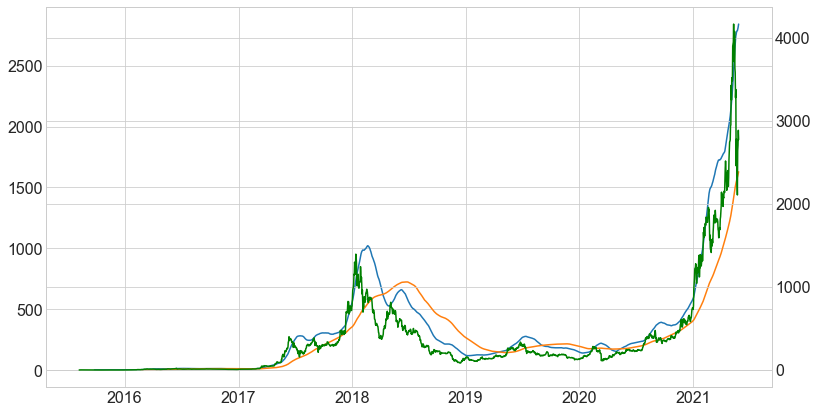

In [238]:
# Close vs rolling Volumes
fig,ax = plt.subplots()
ax.plot(dfm[['rolling_50C', 'rolling_200C']])
ax2=ax.twinx()
ax2.plot(dfm.Close, color='green')

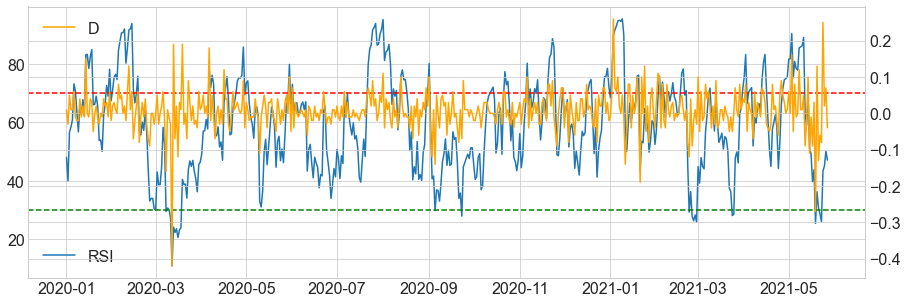

In [239]:
# View RSI Indicator and compare vs Close price
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(dfm.RSI14['2020':])
plt.axhline(y = 70, color ="red", linestyle ="--")
plt.axhline(y = 30, color ="green", linestyle ="--")
plt.legend(['RSI'])
ax2=ax.twinx()
ax2.plot(dfm['2020':].close_DoD, color='orange')
plt.legend('DoD')

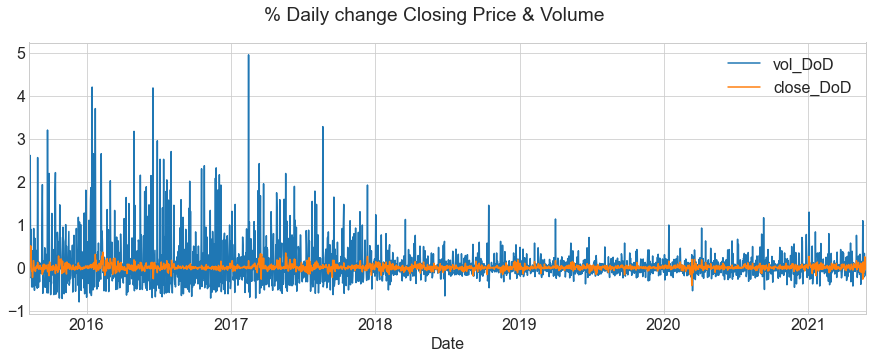

In [240]:
fig, axes = plt.subplots(1, 1,figsize=(15,5))
fig.suptitle('% Daily change Closing Price & Volume')
dfm['vol_DoD'].plot()
dfm['close_DoD'].plot()
plt.legend()

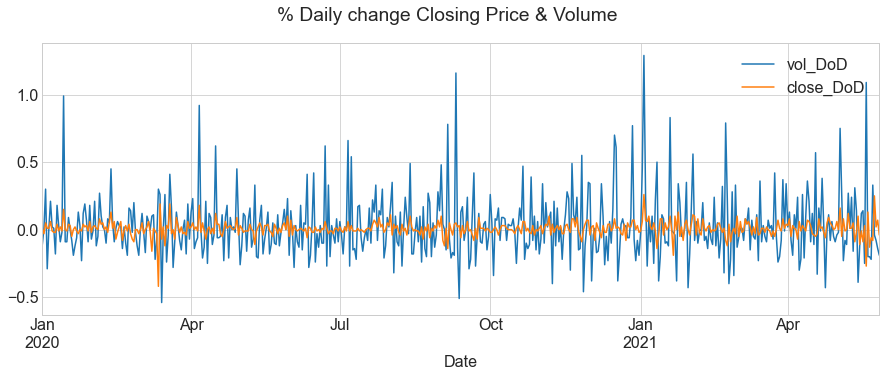

In [241]:
fig, axes = plt.subplots(1, 1,figsize=(15,5))
fig.suptitle('% Daily change Closing Price & Volume')
dfm['2020':]['vol_DoD'].plot()
dfm['2020':]['close_DoD'].plot()
plt.legend()

Note: on the longer data timeline it was hard to identify some connection b/w price and volume but there definitely appears to be one after zooming in a bit 